In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import copy
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
sys.path.append(parent_dir)

# Regular Imports 
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from tqdm import tqdm
import matplotlib.pyplot as plt

from inference.distribution import Gaussian

# Distributions

## Target Distribution $\phi^4$
We load premade samples from a `torch.Tensor` of shape `(batch_size, lattice_points, lattice_points)`

In [3]:
from inference.distribution import Sampleable
class EmpiricalPhi4(Sampleable):

    def __init__(self, samples: torch.Tensor, device = None):
        self._samples = samples.to(device)
        self._lattice_size = int(samples.shape[-1])
        
    @property
    def dim(self):
        shape = self._samples.shape
        return shape[-1] * shape[-2]

    def sample(self, num_samples: int):
        '''
        Returns
            Shape (num_samples, L, L)
        '''
        batch_size = self._samples.shape[0]
        if num_samples > batch_size:
            raise ValueError(f"num_samples ({num_samples}) cannot exceed batch_size ({batch_size})")

        indices = torch.randperm(batch_size)[:num_samples]
        return self._samples[indices]
    

# Load Phi4 Samples
samples = torch.load('phi4_coupling0p02_kinetic0p3.pt', map_location=torch.device('cpu')) # Shape (batch_size, L, L)
dist_phi4 = EmpiricalPhi4(samples=samples)

## Easy to Sample Distribution

In [4]:
class GaussianNoise(Sampleable):

    def __init__(self, lattice_size, device = None):
        self._lattice_size = lattice_size
        self.device = device

    @property
    def dim(self):
        return self._lattice_size ** 2
    
    def sample(self, num_samples: int) -> torch.Tensor:
        return torch.rand(num_samples, self._lattice_size, self._lattice_size, device=self.device)


# Machine Learning

## Model

In [66]:
import torch.jit as jit
from typing import List, Type


def build_mlp(dims: List[int], activation: Type[torch.nn.Module] = torch.nn.SiLU):
        mlp = []
        for idx in range(len(dims) - 1):
            mlp.append(torch.nn.Linear(dims[idx], dims[idx + 1]))
            if idx < len(dims) - 2:
                mlp.append(activation())
        return torch.nn.Sequential(*mlp)

class MLPVectorField(jit.ScriptModule):
    """
    MLP-parameterization of the learned vector field u_t^theta(x)
    """
    def __init__(self, dim: int, hiddens: List[int]):
        super().__init__()
        self.dim = dim
        self.net = build_mlp([dim+1] + hiddens + [dim])

    @jit.script_method
    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        Args:
        - x: (bs, L, L)
        - t: (bs, 1, 1)
        Returns:
        - u_t^theta(x): (bs, L, L)

        """
        og_shape = x.shape # (bs, L, L)

        x = x.view(x.shape[0], -1)  # shape: (bs, L*L)
        t = t.view(-1, 1)           # shape: (bs, 1)
        xt = torch.cat([x, t], dim=-1)  # shape: (bs, L*L + 1)
        xt = self.net(xt)

        return xt.view(og_shape)        # reshape to (bs, L, L)

## Trainer

In [67]:
from inference.sde import SDE, EulerMaruyamaSimulator
from learning.train import Trainer
from inference.path import ConditionalProbabilityPath


class LangevinDynamics(SDE):
    ''' 
    Implements

    dX_t = (sigma_t^2 / 2) s(x) dt + sigma_t dW_t
    
    where s(x) = nabla_x log p(x)
    '''
    
    def __init__(self, score, noise_scheduler: torch.Tensor):
        '''
        The score is of the form `\nabla_x \log p(x)`

        The limiting distribution of LangevinDynamics is `p(x)`

        Args:
            score (func): Inputs tensor of shape (batch_size, dim), outputs tensor of shape (batch_size, dim).
                Can be `distribution.Density.score`.
            noise_scheduler: Inputs torch tensor (batch_size, 1), outputs tensor of shape (batch_size, 1)
        '''
        self.score = score
        self.noise_scheduler = noise_scheduler

    def drift_coefficient(self, xt: torch.Tensor, t: torch.Tensor):
        '''
        Args:
            xt: (batch_size, L, L)
            t: (batch_size, 1, 1)
        Returns:
            drift: (batch_size, L, L)
        '''
        _, dim, dim = xt.shape
        # noise = self.noise_scheduler(t).repeat(1, dim, dim)

        t = t.repeat(xt.shape[0], 1, 1)
        return self.score(xt, t)
    
    def diffusion_coefficient(self, xt: torch.Tensor, t: torch.Tensor):
        _, dim, dim = xt.shape
        noise = self.noise_scheduler(t).repeat(1, dim)

        return noise

class ConditionalFlowMatchingTrainer(Trainer):
    def __init__(self, 
                 path: ConditionalProbabilityPath, 
                 model: MLPVectorField,
                 **kwargs):
        super().__init__(model, **kwargs)
        self.path = path

    def get_train_loss(self, batch_size: int) -> torch.Tensor:
        z = self.path.p_data.sample(batch_size)
        t = torch.rand(batch_size, 1, 1) # (batch_size, 1, 1)
        x = self.path.sample_conditional_path(z,t) # (batch_size, lattice_size, lattice_size)

        u_model = self.model(x,t)
        u_ref = self.path.conditional_vector_field(x,z,t)

        return torch.norm(u_model - u_ref) / batch_size
    
    def inference(self, 
                  num_samples: int,
                  ts: torch.Tensor,
                  use_tqdm: bool = False
                  ):
        sde = LangevinDynamics(score=self.model, noise_scheduler=lambda t: torch.ones_like(t))
        simulator= EulerMaruyamaSimulator(sde)
        
        x_init = self.path.p_data.sample(num_samples)
        x_final = simulator.simulate(x=x_init, ts=ts, use_tqdm=use_tqdm)

        return x_final

<>:16: SyntaxWarning: invalid escape sequence '\l'
<>:16: SyntaxWarning: invalid escape sequence '\l'
/var/folders/wd/zr_by8q96891mxc_506sm9sr0000gn/T/ipykernel_38167/960032348.py:16: SyntaxWarning: invalid escape sequence '\l'
  '''


In [68]:
from inference.path import LinearConditionalProbabilityPath

# Construct conditional probability path
path = LinearConditionalProbabilityPath(
    p_simple = GaussianNoise(lattice_size=dist_phi4._lattice_size),
    p_data = dist_phi4
).to(device)

# Construct learnable vector field
linear_flow_model = MLPVectorField(dim=dist_phi4.dim, hiddens=[128,128,128,128,128])

# Construct trainer
trainer = ConditionalFlowMatchingTrainer(path, linear_flow_model)

losses = trainer.train(num_epochs=10000, device=device, lr=1e-5, batch_size=8000)

Epoch 2813, loss: 0.2506362199783325: : 2814it [05:58,  7.84it/s] 


KeyboardInterrupt: 

# Results
## Visual

100%|██████████| 999/999 [00:14<00:00, 66.81it/s]


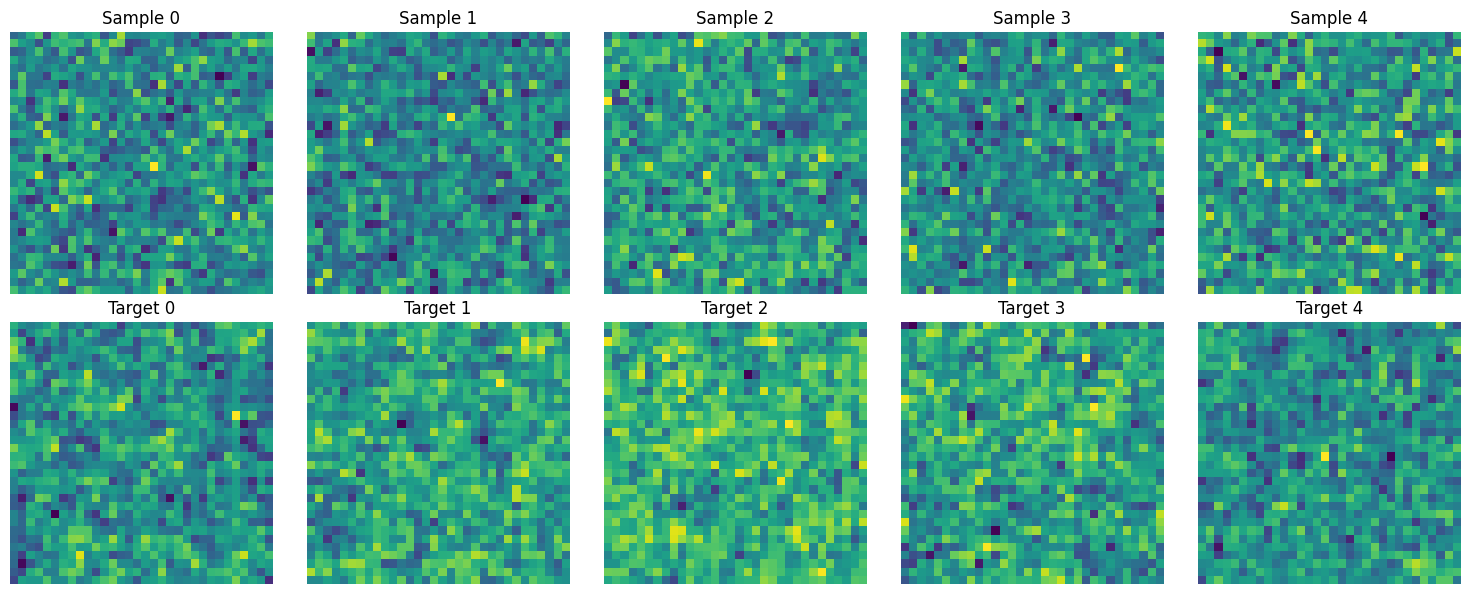

In [28]:
num_samples = 1000

ts = torch.linspace(0, 1, 1000).unsqueeze(-1).unsqueeze(-1).to(device)
samples = trainer.inference(num_samples=num_samples, ts=ts, use_tqdm=True)

# Plot some samples
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    axes[0, i].imshow(samples[i].cpu().detach())
    axes[0, i].set_title(f'Sample {i}')
    axes[0, i].axis('off')
    
    # Plot corresponding target samples for comparison
    target_sample = dist_phi4.sample(1)[0]
    axes[1, i].imshow(target_sample.cpu().detach())
    axes[1, i].set_title(f'Target {i}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

## Statistical Tests

In [ ]:
from fieldstatistics import compare_statistics, 

compare_statistics(samples, dist_phi4.sample(num_samples))


+-----------+------------------+---------------------+---------------+
| Statistic | Generative Model | Target Distribution | In Tolerance? |
+-----------+------------------+---------------------+---------------+
|     M     | 2.1981 ± 0.0016  |   2.1943 ± 0.0012   |     False     |
|    |M|    | 2.1981 ± 0.0016  |   2.1943 ± 0.0012   |     False     |
|   chi²    | 2.5361 ± 7.0817  |   1.5468 ± 5.5276   |     True      |
+-----------+------------------+---------------------+---------------+


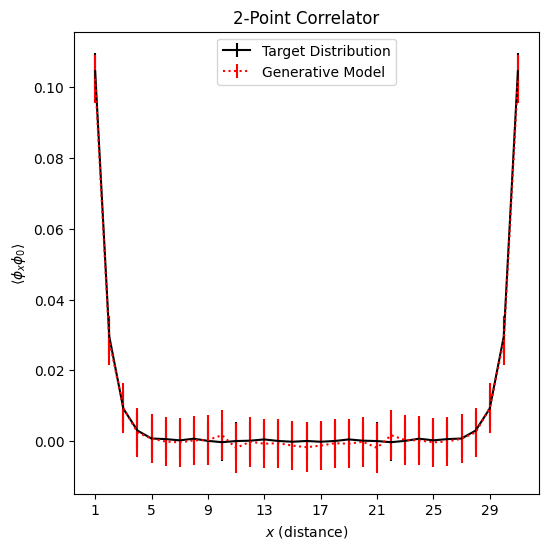

In [62]:
corr_samples = get_corr_func(samples)
corr_target = get_corr_func(dist_phi4.sample(num_samples))

fig, ax = plt.subplots(1,1, figsize=(6,6))
plt.xticks([i for i in range(1, 32, 4)])
ax.errorbar(corr_target[:,0], corr_target[:,1], yerr=corr_target[:,2], label='Target Distribution', color='black')
ax.errorbar(corr_samples[:,0], corr_samples[:,1], yerr=corr_samples[:,2], label='Generative Model', color='red', linestyle=':' )
plt.title('2-Point Correlator')
plt.ylabel(r'$\langle  \phi_x \phi_0 \rangle$')
plt.xlabel('$x$ (distance)')
plt.legend()
plt.show()